# Distance module overview

## Available elastic distances
| Metric | Distance Function       |
|--------|-------------------------|
| dtw    | distance.dtw_distance   |
| ddtw   | distance.ddtw_distance  |
| wdtw   | distance.wdtw_distance  |
| wddtw  | distance.wddtw_distance |
| erp    | distance.erp_distance   |
| edr    | distance.edr_distance   |
| msm    | distance.msm_distance   |
| twe    | distance.twe_distance   |
| lcss   | distance.lcss_distance  |

## Calling a distance function

In [1]:
import numpy as np

# These can be 1d or 2d arrays and in addition they do not have to be equal length
x = np.array([1, 2, 3, 4, 5])
y = np.array([6, 7, 8, 9, 10])

# Calling a distance directly
from aeon.distances import dtw_distance

dtw_distance(x, y)

# Calling a distance using utility function
from aeon.distances import distance

# Any value in the table above is a valid metric string
distance(x, y, metric="dtw")

108.0

## Distance function parameters

You pass parameters as kwargs to a distance. The parameters for each distance
are documented at https://www.aeon-toolkit.org/en/latest/api_reference/distances.html.

To pass parameters to utility function just specify the kwargs after the metric
parameter.

Below shows using the window parameter for DTW.

In [3]:
# Calling a distance directly
from aeon.distances import msm_distance

msm_distance(x, y, window=0.2)

# Calling a distance using utility function
distance(x, y, metric="msm", window=0.2)

2.0

# Other distance module functionality

## Pairwise distance
If we have a collection of time series (or dataset) and we want to find the distance
between each pair of time series we can use the pairwise distance function.

In [4]:
X = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [11, 12, 13, 14, 15]])

# Calling a distance directly
from aeon.distances import twe_pairwise_distance

twe_pairwise_distance(X)

# Using utility function
from aeon.distances import pairwise_distance

pairwise_distance(X, metric="twe")

array([[ 0.   , 21.008, 26.008],
       [21.008,  0.   , 21.008],
       [26.008, 21.008,  0.   ]])

We can also compute the pairwise distance between two different collections of time series.

In [5]:
y = np.array([[16, 17, 18, 19, 20], [21, 22, 23, 24, 25]])

# Calling a distance directly
from aeon.distances import erp_pairwise_distance

erp_pairwise_distance(X, y)

# Using utility function
pairwise_distance(X, y, metric="erp")

array([[ 75., 100.],
       [ 50.,  75.],
       [ 25.,  50.]])

## Pairwise distance parameters

Pairwise distance functions take the same parameters as the distance functions and
you pass them in the same way. They MUST be passed by kwargs.

<h1>Lets do the time warp again: time series machine learning with distance functions</h1>

In [6]:
# Calling a distance directly
from aeon.distances import wdtw_pairwise_distance

wdtw_pairwise_distance(X, y, window=0.2)

# Using utility function
pairwise_distance(X, y, metric="wdtw", window=0.2)

array([[527.38945495, 937.58125325],
       [234.39531331, 527.38945495],
       [ 54.24009352, 234.39531331]])

# Alignment paths
Elastic distances compute a 'better' distance by realigning the time series. This
is done by computing an alignment path between the time series and then using this
path to compute the distance. The alignment path can be explicitly found using the
alignment_path function.

The alignment path function returns a tuple where the first element is an alignment
path. This is a list of index alignment pairs, where the first index is a position in
the first series and the second is an index in the second series. The second
returned value is the distance between the two time series.

In [7]:
x = np.array([1, 2, 3, 4, 5])
y = np.array([6, 7, 8, 9, 10])
# Calling a alignment path directly
from aeon.distances import msm_alignment_path

msm_alignment_path(x, y)

# Using utility function
from aeon.distances import alignment_path

alignment_path(x, y, metric="msm", window=0.2)

([(0, 0), (0, 1), (0, 2), (1, 3), (2, 4), (3, 4), (4, 4)], 2.0)

In [8]:
# We can visualise the alignment path using the plot_alignment_path function


def setup_time_axes(data: np.ndarray):
    """Set up and return a figure and axes for time series plotting."""
    fig, ax = plt.subplots(1, 1, figsize=(20, 4), dpi=300)
    fig.set_facecolor("white")
    ax.set_facecolor("white")

    ax.grid(color="white", linewidth=0.1, alpha=0.3, zorder=0)
    ax.axis("off")

    return fig, ax


def plot_alignment(x, y, path):
    """Plot the alignment between two time series with a given path."""
    time = np.arange(len(x))
    fig, ax = setup_time_axes(np.vstack([x, y]))
    # Plot the first time series
    ax.plot(time, x, marker="o", linestyle="-")

    # Plot the second time series
    ax.plot(time, y, marker="x", linestyle="-")

    for i, j in path:
        ax.plot([time[i], time[j]], [x[i], y[j]], "--", linewidth=0.5, color="gray")

    return plt

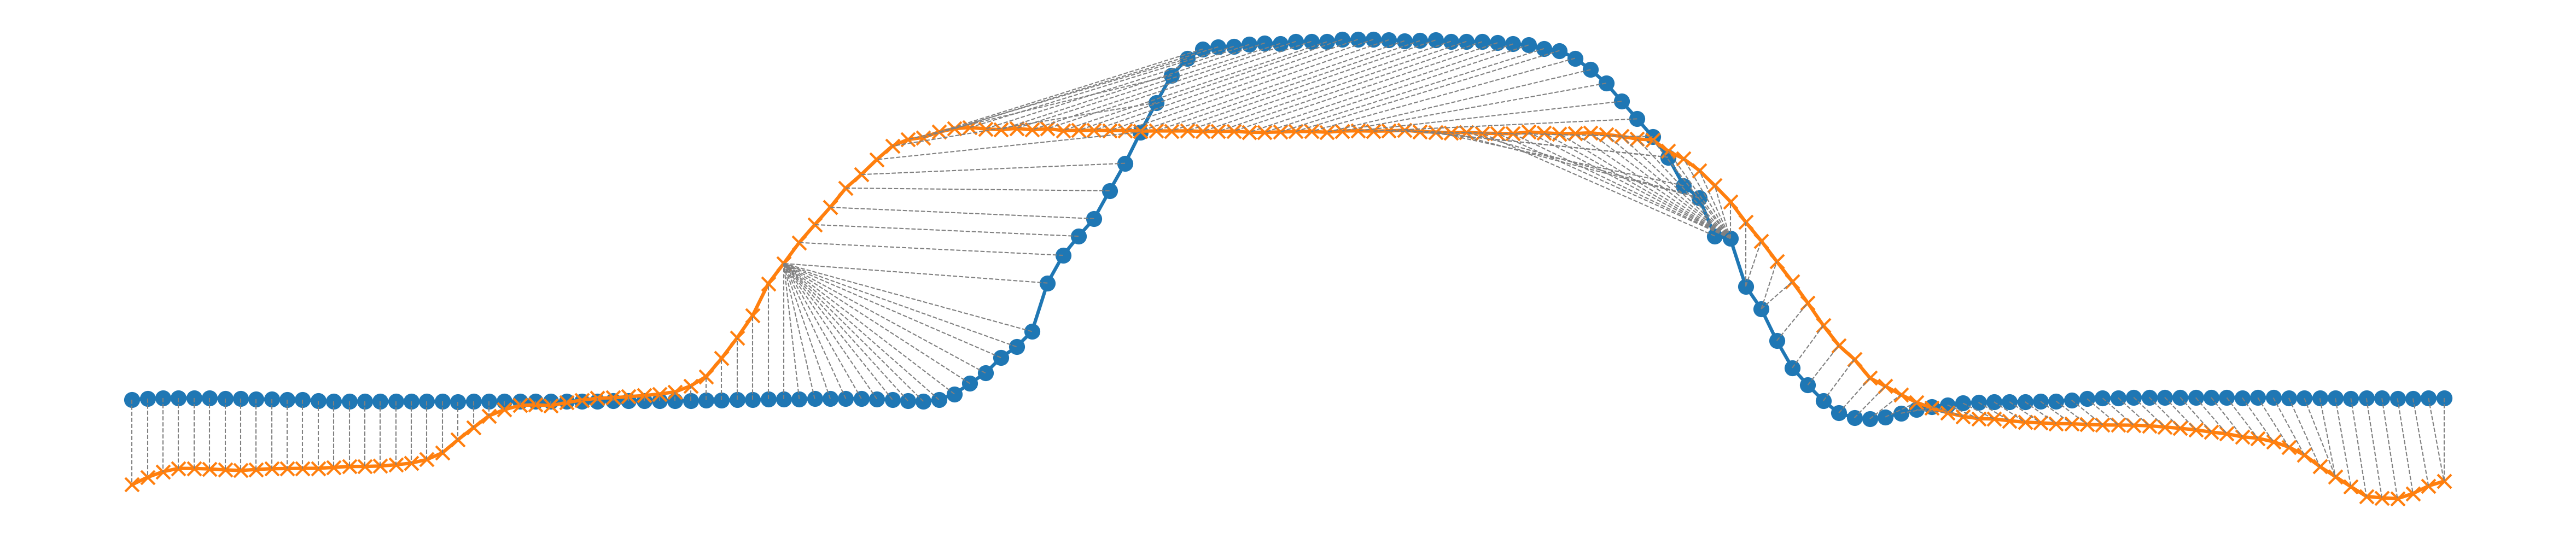

In [17]:
import matplotlib.pyplot as plt

from aeon.datasets import load_gunpoint as load_data

X_train, y_train = load_data(split="TRAIN", return_type="numpy2D")
X_test, y_test = load_data(split="TEST", return_type="numpy2D")
x = X_train[0]
y = X_train[22]
msm_alignment_path = alignment_path(x, y, metric="msm")
curr_plot = plot_alignment(x, y, msm_alignment_path[0])
curr_plot.show()

# Using distances with sklearn

All of our distance functions are compatible with sklearn distance based estimators

In [11]:
from aeon.datasets import load_gunpoint as load_data

X_train, y_train = load_data(split="TRAIN", return_type="numpy2D")
X_test, y_test = load_data(split="TEST", return_type="numpy2D")

# Clustering

In [12]:
from sklearn.cluster import AgglomerativeClustering

from aeon.distances import pairwise_distance, twe_pairwise_distance

model_precomputed = AgglomerativeClustering(metric="precomputed", linkage="complete")
model_distance = AgglomerativeClustering(
    metric=twe_pairwise_distance, linkage="complete"
)

# Precompute pairwise twe distances
train_pw_distance = pairwise_distance(X_train, metric="twe")

# Fit model using precomputed
model_precomputed.fit(train_pw_distance)
# Fit model using distance function
model_distance.fit(X_train)
#
# Score models on training data
print("DBSCAN with twe distance labels: ", model_distance.labels_)
print("DBSCAN with precomputed labels: ", model_precomputed.labels_)

DBSCAN with twe distance labels:  [1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 0
 1 0 0 1 1 1 1 0 1 1 1 1 0]
DBSCAN with precomputed labels:  [1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 0
 1 0 0 1 1 1 1 0 1 1 1 1 0]


## Classification

In [13]:
from sklearn.svm import SVC

from aeon.distances import msm_pairwise_distance, pairwise_distance

model_precomputed = SVC(kernel="precomputed")
model_distance = SVC(kernel=msm_pairwise_distance)

# Precompute pairwise twe distances
train_pw_distance = pairwise_distance(X_train, metric="msm")
test_pw_distance = pairwise_distance(X_test, X_train, metric="msm")

# Fit model using precomputed
model_precomputed.fit(train_pw_distance, y_train)
# Fit model using distance function
model_distance.fit(X_train, y_train)

# Score models on training data
print("SVM with twe distance score: ", model_distance.score(X_test, y_test))
print("SVM with precomputed score: ", model_precomputed.score(test_pw_distance, y_test))

SVM with twe distance score:  0.38666666666666666
SVM with precomputed score:  0.38666666666666666
